# Sufficient Context Ratings for the FreshStack Angular benchmark

Paper link: https://arxiv.org/abs/2411.06037

In [2]:
from datasets import load_dataset

def _in_memory_dataset_loader_freshstack(subset: str):
    docs = _load_dataset_from_hf_hub(filepath="freshstack/corpus-oct-2024", subset=subset)
    for doc in docs:
        doc['dataset_id'] = doc.pop('_id')
    questions = _load_dataset_from_hf_hub(
        filepath="freshstack/queries-oct-2024", 
        subset=subset, 
        train=False
    )

    for question in questions:
        all_relevant_ids = []
        nugget_data = []
        ids_per_nugget = {}
        
        for i, nugget in enumerate(question.get('nuggets', [])):
            nugget_id = f"{question['query_id']}_nugget_{i}"
            nugget_text = nugget['text']
            relevant_corpus_ids = nugget['relevant_corpus_ids']
            
            nugget_info = {
                'nugget_id': nugget_id,
                'text': nugget_text,
                'relevant_corpus_ids': relevant_corpus_ids
            }
            nugget_data.append(nugget_info)
            all_relevant_ids.extend(relevant_corpus_ids)
            
            ids_per_nugget[nugget_text] = relevant_corpus_ids
        
        unique_relevant_ids = list(dict.fromkeys(all_relevant_ids))
        
        question['dataset_ids'] = unique_relevant_ids
        question['ids_per_nugget'] = ids_per_nugget
        question['nugget_data'] = nugget_data
        question['num_nuggets'] = len(nugget_data)
        question["question"] = question["query_text"]
    
    return docs, questions

def _load_dataset_from_hf_hub(filepath, subset=None, train=True):
    ds = load_dataset(filepath, subset)
    if train:
        train_dataset = ds["train"]
    else:
        train_dataset = ds["test"]
    
    dataset_dicts = []
    for item in train_dataset:
        dataset_dicts.append(dict(item))
    
    return dataset_dicts

In [3]:
angular_docs, angular_questions = _in_memory_dataset_loader_freshstack(subset="angular")

In [4]:
angular_docs[0]

{'text': '# Contributor Covenant Code of Conduct\n\n## Our Pledge\n\nIn the interest of fostering a safe and welcoming environment, we as\nthe Angular team pledge to make participation in our project and\nour community a harassment-free experience for everyone, regardless of age, body\nsize, disability, ethnicity, sex characteristics, gender identity, gender expression,\nlevel of experience, education, socio-economic status, nationality, personal\nappearance, race, religion, or sexual identity and orientation.\n\n## Our Standards\n\nExamples of behavior that contributes to creating a positive environment\ninclude:\n\n* Use welcoming and inclusive language\n* Respect each other\n* Provide and gracefully accept constructive criticism\n* Show empathy towards other community members\n\nExamples of unacceptable behavior by participants include:\n\n* Trolling, insulting/derogatory comments, and personal or political attacks\n* Public or private harassment\n* Publishing others\' private infor

In [10]:
angular_docs_dict = {doc['dataset_id']: doc['text'] for doc in angular_docs}

In [12]:
angular_questions[0]["nugget_data"]

[{'nugget_id': '76185522_nugget_0',
  'text': 'The Angular Router needs to bind data and resolve properties to component inputs.',
  'relevant_corpus_ids': ['angular/packages/router/test/directives/router_outlet.spec.ts_6016_13626',
   'angular/packages/router/src/provide_router.ts_18034_25289',
   'angular/packages/router/test/recognize.spec.ts_5870_8306',
   'angular/packages/router/src/models.ts_10753_17056']},
 {'nugget_id': '76185522_nugget_1',
  'text': 'Use withComponentInputBinding() as a second parameter in the provideRouter function to enable this binding.',
  'relevant_corpus_ids': ['angular/packages/router/test/directives/router_outlet.spec.ts_6016_13626',
   'angular/packages/router/src/provide_router.ts_18034_25289']}]

In [13]:
key_test = angular_questions[0]["nugget_data"][0]["relevant_corpus_ids"][0]

In [14]:
angular_docs_dict[key_test]

"describe('component input binding', () => {\n  it('sets component inputs from matching query params', async () => {\n    @Component({\n      template: '',\n      standalone: false,\n    })\n    class MyComponent {\n      @Input() language?: string;\n    }\n\n    TestBed.configureTestingModule({\n      providers: [\n        provideRouter([{path: '**', component: MyComponent}], withComponentInputBinding()),\n      ],\n    });\n    const harness = await RouterTestingHarness.create();\n\n    const instance = await harness.navigateByUrl('/?language=english', MyComponent);\n    expect(instance.language).toEqual('english');\n\n    await harness.navigateByUrl('/?language=french');\n    expect(instance.language).toEqual('french');\n\n    // Should set the input to undefined when the matching router data is removed\n    await harness.navigateByUrl('/');\n    expect(instance.language).toEqual(undefined);\n    await harness.navigateByUrl('/?notlanguage=doubletalk');\n    expect(instance.language)

Total number of questions: 129
Mean tokens per question: 15793
Median tokens per question: 14315
Min tokens per question: 1632
Max tokens per question: 57828


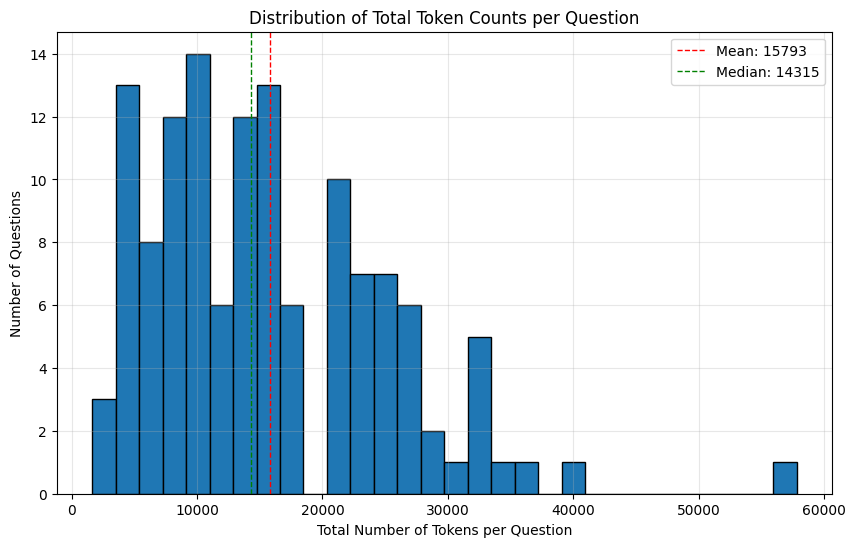

In [21]:
import tiktoken
import matplotlib.pyplot as plt
import numpy as np

def get_relevant_contexts(question, docs_dict):
    """Get all relevant contexts for a question's nuggets."""
    contexts = []
    for nugget in question["nugget_data"]:
        for corpus_id in nugget["relevant_corpus_ids"]:
            if corpus_id in docs_dict:
                contexts.append({
                    "context": docs_dict[corpus_id]
                })
    return contexts

# Get contexts grouped by question
question_contexts = []
for question in angular_questions:
    contexts = get_relevant_contexts(question, angular_docs_dict)
    question_contexts.append({
        "question": question["question"],
        "contexts": contexts
    })

# Count tokens per question (sum of all contexts for that question)
enc = tiktoken.get_encoding("cl100k_base")
token_counts = []
for qc in question_contexts:
    total_tokens = sum(len(enc.encode(context["context"])) for context in qc["contexts"])
    token_counts.append(total_tokens)

# Create histogram of token counts per question
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, edgecolor='black')
plt.title('Distribution of Total Token Counts per Question')
plt.xlabel('Total Number of Tokens per Question')
plt.ylabel('Number of Questions')
plt.grid(True, alpha=0.3)

# Add summary statistics
mean_tokens = np.mean(token_counts)
median_tokens = np.median(token_counts)
plt.axvline(mean_tokens, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tokens:.0f}')
plt.axvline(median_tokens, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_tokens:.0f}')
plt.legend()

print(f"Total number of questions: {len(question_contexts)}")
print(f"Mean tokens per question: {mean_tokens:.0f}")
print(f"Median tokens per question: {median_tokens:.0f}")
print(f"Min tokens per question: {min(token_counts)}")
print(f"Max tokens per question: {max(token_counts)}")

Total number of questions: 129
Mean tokens per question: 3698
Median tokens per question: 3501
Min tokens per question: 118
Max tokens per question: 10027


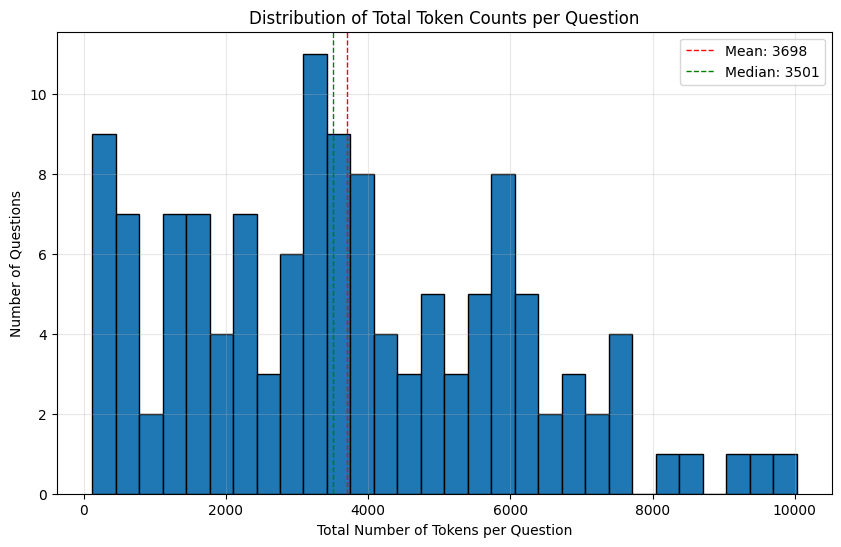

In [32]:
import tiktoken
import matplotlib.pyplot as plt
import numpy as np

def get_relevant_contexts(question, docs_dict):
    """Get all relevant contexts for a question's nuggets."""
    contexts = []
    for i, nugget in enumerate(question["nugget_data"], 1):
        if nugget["relevant_corpus_ids"] and nugget["relevant_corpus_ids"][0] in docs_dict:
            contexts.append(f"Search Result {i}\n{docs_dict[nugget['relevant_corpus_ids'][0]]}")
    return "\n\n".join(contexts)

# Get contexts grouped by question
questions_with_contexts = []
for question in angular_questions:
    contexts = get_relevant_contexts(question, angular_docs_dict)
    questions_with_contexts.append({
        "question": question["question"],
        "contexts": contexts
    })

# Count tokens per question (sum of all contexts for that question)
enc = tiktoken.get_encoding("cl100k_base")
token_counts = []
for qc in questions_with_contexts:
    total_tokens = len(enc.encode(qc["contexts"]))
    token_counts.append(total_tokens)

# Create histogram of token counts per question
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, edgecolor='black')
plt.title('Distribution of Total Token Counts per Question')
plt.xlabel('Total Number of Tokens per Question')
plt.ylabel('Number of Questions')
plt.grid(True, alpha=0.3)

# Add summary statistics
mean_tokens = np.mean(token_counts)
median_tokens = np.median(token_counts)
plt.axvline(mean_tokens, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tokens:.0f}')
plt.axvline(median_tokens, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_tokens:.0f}')
plt.legend()

print(f"Total number of questions: {len(question_contexts)}")
print(f"Mean tokens per question: {mean_tokens:.0f}")
print(f"Median tokens per question: {median_tokens:.0f}")
print(f"Min tokens per question: {min(token_counts)}")
print(f"Max tokens per question: {max(token_counts)}")

In [35]:
import os
import time

import weaviate
import weaviate.collections.classes.config as wvcc

weaviate_client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("WEAVIATE_URL"),
    auth_credentials=weaviate.auth.AuthApiKey(os.getenv("WEAVIATE_API_KEY")),
)

if weaviate_client.collections.exists("FreshstackAngularGold"):
    weaviate_client.collections.delete("FreshstackAngularGold")

weaviate_client.collections.create(
    name="FreshstackAngularGold",
    vectorizer_config=wvcc.Configure.Vectorizer.text2vec_weaviate(),
    properties=[
        wvcc.Property(name="question", data_type=wvcc.DataType.TEXT),
        wvcc.Property(name="contexts", data_type=wvcc.DataType.TEXT),
    ]
)

with weaviate_client.batch.fixed_size(batch_size=100, concurrent_requests=4) as batch:
    for question_with_context in questions_with_contexts:
        batch.add_object(
            collection="FreshstackAngularGold",
            properties={
                "question": question_with_context["question"],
                "contexts": question_with_context["contexts"]
            }
        )

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/weaviate/warnings.py:314: ResourceWarning: Con004: The connection to Weaviate was not closed properly. This can lead to memory leaks.
            Please make sure to close the connection using `client.close()`.
  warnings.warn(
/var/folders/41/8dp_379x15d8zz4ppsjthdw40000gn/T/ipykernel_68651/174038986.py:23: ResourceWarning: unclosed <ssl.SSLSocket fd=98, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.0.0.120', 52992), raddr=('35.201.124.182', 443)>
  with weaviate_client.batch.fixed_size(batch_size=100, concurrent_requests=4) as batch:
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2add63b20>
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2ad08e140>
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/_collections_abc.py:82: ResourceWarning: unclosed <ssl.SSLSocket fd=94, family=AddressFamily.AF_INET, type=SocketKind.SOCK_

In [36]:
from weaviate.agents.transformation import TransformationAgent
from weaviate.agents.classes import Operations
from weaviate.collections.classes.config import DataType

assess_sufficient_context = Operations.append_property(
    property_name="sufficient_context_assessment",
    data_type=DataType.BOOL,
    view_properties=["question", "contexts"],
    instruction="""Determine if the context contains sufficient information to answer the question.

An instance has sufficient context if and only if there exists an answer A' such that A' is a plausible answer to the question given the information in the context.

Key points:
- The context is sufficient if it contains all necessary information to provide a definitive answer
- For multi-hop questions, facts can be combined but unsupported inferences should not be made
- For ambiguous queries, context is sufficient if it can disambiguate AND answer the question
- For ambiguous contexts with multiple plausible answers, sufficient information must exist to distinguish between them

Return True if the context is sufficient to answer the question, False otherwise.
Return only the boolean value."""
)

agent = TransformationAgent(
    client=weaviate_client,
    collection="FreshstackAngularGold",
    operations=[assess_sufficient_context],
)

response = agent.update_all()

In [38]:
agent.get_status(workflow_id=response.workflow_id)

{'workflow_id': 'TransformationWorkflow-b434ee69b8848a2e083430f39797d47f',
 'status': {'batch_count': 1,
  'end_time': '2025-06-06 13:59:37',
  'start_time': '2025-06-06 13:56:49',
  'state': 'completed',
  'total_duration': 168.865235,
  'total_items': 129}}

In [39]:
from weaviate.agents.query import QueryAgent
from weaviate.agents.utils import print_query_agent_response

qa = QueryAgent(
    client=weaviate_client, collections=["FreshstackAngularGold"]
)

response = qa.run("What percentage of questions are assessed to have sufficient context?")
print_query_agent_response(response)

╭─────────────────────────────────────────────── 🔍 Original Query ───────────────────────────────────────────────╮
│                                                                                                                 │
│ What percentage of questions are assessed to have sufficient context?                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📝 Final Answer ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Approximately 91.47% of the questions are assessed to have sufficient context. This means that out of the total │
│ questions evaluated, about 118 were deemed to have enough context, while around 11 questions were considered    │
│ lacking sufficient context. Thus, the vast majority of questions meet the criteria for sufficient context.      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔭 No Searches Run                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── 📊 Aggregations Run 1/1 ────────────────────────────────────────────╮
│                                                                                                                 │
│ AggregationResultWithCollection(                                                                                │
│     search_query=None,                                                                                          │
│     groupby_property=None,                                                                                      │
│     aggregations=[                                                                                              │
│         BooleanPropertyAggregation(                                                                             │
│             property_name='sufficient_context_assessment',                                                      │
│             metrics=<BooleanMetrics.PERCENTAGE_TRUE: 'PERCENTAGE_TRUE'>                                         │
│         )                                                                                                       │
│     ],                                                                                                          │
│     filters=[],                                                                                                 │
│     collection='FreshstackAngularGold'                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

   📊 Usage Statistics   
┌────────────────┬──────┐
│ LLM Requests:  │ 3    │
│ Input Tokens:  │ 8645 │
│ Output Tokens: │ 229  │
│ Total Tokens:  │ 8874 │
└────────────────┴──────┘

Total Time Taken: 6.69s

In [40]:
response = qa.run("""
Could you analyze a couple of the questions judged not to have sufficient context? What are they lacking?
""")
print_query_agent_response(response)

╭─────────────────────────────────────────────── 🔍 Original Query ───────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ Could you analyze a couple of the questions judged not to have sufficient context? What are they lacking?       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📝 Final Answer ────────────────────────────────────────────────╮
│                                                                                                                 │
│ Two example questions judged not to have sufficient context and what they are lacking are as follows:           │
│                                                                                                                 │
│ 1. The first question concerns an error in an Angular 17 project where the user tries to display charts using   │
│ AG Charts modules but gets an "unable to resolve global window" error. This question lacks context about the    │
│ platform environment (server/browser) where the code is running, and how the Angular Universal or server-side   │
│ rendering considerations have been handled. It does not provide details about whether the code is running on    │
│ the server or browser, or what precautions have been taken for browser globals like `window`. This lack of      │
│ context makes it hard to understand why the error occurs or how exactly to fix it.                              │
│                                                                                                                 │
│ 2. The second example involves a user trying to get sorted data from MatTableDataSource in Angular 16 but       │
│ encounters a type error when passing a potentially null MatSort object to a function expecting a non-null       │
│ MatSort. This question lacks specifics about the state of the MatSort (e.g., whether it is properly initialized │
│ or assigned before usage) and does not provide code showing the initialization or assignment. There is          │
│ insufficient context regarding the timing or lifecycle of the sort property, making it difficult to diagnose or │
│ suggest fixes.                                                                                                  │
│                                                                                                                 │
│ Overall, these questions lack crucial contextual information such as environment details (SSR vs browser),      │
│ lifecycle state, initialization patterns, or platform specifics necessary to understand the root cause of their │
│ issues and provide targeted advice.                                                                             │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────── 🔭 Searches Executed 1/1 ────────────────────────────────────────────╮
│                                                                                                                 │
│ QueryResultWithCollection(                                                                                      │
│     queries=['questions not judged to have sufficient context'],                                                │
│     filters=[                                                                                                   │
│         [                                                                                                       │
│             BooleanPropertyFilter(                                                                              │
│                 property_name='sufficient_context_assessment',                                                  │
│                 operator=<ComparisonOperator.EQUALS: '='>,                                                      │
│                 value=False                                                                                     │
│             )                                                                                                   │
│         ]                                                                                                       │
│     ],                                                                                                          │
│     filter_operators='AND',                                                                                     │
│     collection='FreshstackAngularGold'                                                                          │
│ )                                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 📊 No Aggregations Run                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── 📚 Sources ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  - object_id='a3427ff4-2779-4f61-94a7-a2ee7128f09b' collection='FreshstackAngularGold'                          │
│  - object_id='8d70ec8d-ed99-40a0-b463-280da1d8818a' collection='FreshstackAngularGold'                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

   📊 Usage Statistics    
┌────────────────┬───────┐
│ LLM Requests:  │ 3     │
│ Input Tokens:  │ 27944 │
│ Output Tokens: │ 427   │
│ Total Tokens:  │ 28371 │
└────────────────┴───────┘

Total Time Taken: 9.11s